In [1]:
from glob import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from pillow_heif import register_heif_opener
import albumentations as A
import numpy as np

register_heif_opener()


In [2]:
device = torch.device("cuda")

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.max_pool = nn.MaxPool2d(2)
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding='same')
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding='same')

    def forward(self, x):
        x = self.max_pool(x)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return x

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up_conv = nn.ConvTranspose2d(in_channels, out_channels, 2, 2)
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding='same')
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding='same')

    
    def forward(self, x, resid):
        x = F.relu(self.up_conv(x))
        assert x.shape == resid.shape
        x = torch.cat((resid, x), dim=1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return x

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, padding='same')
        self.conv2 = nn.Conv2d(64, 64, 3, padding='same')
        self.enc1 = EncoderBlock(64, 128)
        self.enc2 = EncoderBlock(128, 256)
        self.enc3 = EncoderBlock(256, 512)
        self.enc4 = EncoderBlock(512, 1024)
        self.dec4 = DecoderBlock(1024, 512)
        self.dec3 = DecoderBlock(512, 256)
        self.dec2 = DecoderBlock(256, 128)
        self.dec1 = DecoderBlock(128, 64)
        self.head = nn.Conv2d(64, 3, 1, padding='same')

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x0 = x
        x1 = self.enc1(x0)
        x2 = self.enc2(x1)
        x3 = self.enc3(x2)
        x = self.enc4(x3)

        x = self.dec4(x, x3)
        x = self.dec3(x, x2)
        x = self.dec2(x, x1)
        x = self.dec1(x, x0)
        x = self.head(x)
        return x

In [3]:
model = UNet().to(device)

In [4]:
class ColoringDataset(Dataset):
    def __init__(self, base_path):
        self.image_paths = glob("%s/*" % base_path)
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        image = image.resize((512,384))
        grey_image = image.convert('L')

        image = np.array(image, dtype=np.float32)
        image -= np.array([0.485, 0.456, 0.406]) * 255.0
        image /= np.array([0.229, 0.224, 0.225]) * 255.0
        image = np.transpose(image, (2, 0, 1))

        grey_image = np.array(grey_image, dtype=np.float32)
        grey_image -= np.mean([0.485, 0.456, 0.406]) * 255.0
        grey_image /= np.mean([0.229, 0.224, 0.225]) * 255.0
        grey_image = np.transpose(grey_image, (0, 1))
        grey_image = grey_image[None,]
        return grey_image, image

In [5]:
train_dataset = ColoringDataset("train_images")
train_data_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True, num_workers=8)

val_dataset = ColoringDataset("val_images")
val_data_loader = DataLoader(dataset=val_dataset, batch_size=16)

In [6]:
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [9]:
NUM_EPOCH = 10

for i in range(NUM_EPOCH):
    model.eval()
    for x, y in val_data_loader:
        x = x.to(device)
        y = y.to(device)
    
        with torch.no_grad():
            outputs = model(x)
            loss = loss_func(outputs, y)
            print("val loss: ", loss.item())
    
    model.train()
    for x, y in train_data_loader:
        x = x.to(device)
        y = y.to(device)
    
        optimizer.zero_grad()
        outputs = model(x)
        loss = loss_func(outputs, y)
        loss.backward()
        print("train loss: ", loss.item())
        optimizer.step()

val loss:  0.24699006974697113
train loss:  0.19736896455287933
train loss:  0.23621363937854767
train loss:  0.15324629843235016
train loss:  0.22275815904140472
train loss:  0.18245083093643188
train loss:  0.25495052337646484
train loss:  0.12892085313796997
val loss:  0.2319091111421585
train loss:  0.15698902308940887
train loss:  0.16764378547668457
train loss:  0.20198287069797516
train loss:  0.16710001230239868
train loss:  0.19181624054908752
train loss:  0.29634612798690796
train loss:  0.2527138292789459
val loss:  0.22626443207263947
train loss:  0.13636036217212677
train loss:  0.18272283673286438
train loss:  0.2700870633125305
train loss:  0.19295808672904968
train loss:  0.19616396725177765
train loss:  0.1773809939622879
train loss:  0.178972527384758
val loss:  0.20121659338474274
train loss:  0.23222361505031586
train loss:  0.24851645529270172
train loss:  0.15835689008235931
train loss:  0.20515471696853638
train loss:  0.15759222209453583
train loss:  0.141200065

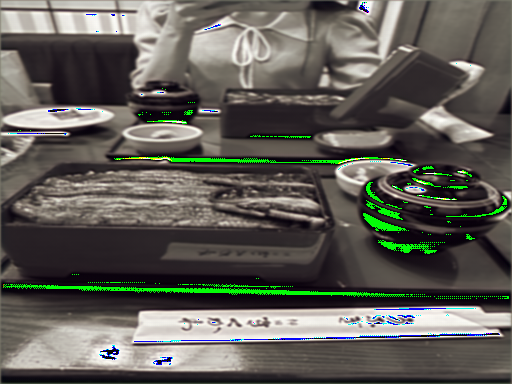

In [10]:
x, y = next(iter(val_data_loader))
x = x.to(device)

with torch.no_grad():
    output = model(x)
    output = output[0].permute((1, 2, 0))
    output *= torch.tensor([0.229, 0.224, 0.225], device=device) * 255.0
    output += torch.tensor([0.485, 0.456, 0.406], device=device) * 255.0
    output = torch.clamp(output.byte(), 0, 255)
    output = output.cpu().numpy()

Image.fromarray(output)